# Instacart

The goal of this project is to predict what items instacart users, the users in the test set more specifically, will order in an future order.  The key metric to optimize, as defined in the problem statement, is the F1 score.    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns; sns.set()
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Dropout
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### Load and Join the Data

In [2]:
# read the training orders 
train_orders = pd.read_csv('data450/order_products__train.csv')
train_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
print("# of observations in training set:  ", train_orders.shape[0])

# of observations in training set:   1384617


In [7]:
# read prior orders
prior_orders = pd.read_csv('data450/order_products__prior.csv')
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
print("# of observations in prio set:  ", prior_orders.shape[0])

# of observations in prio set:   32434489


In [9]:
# always a good idea to check for missing data before moving full steam ahead
train_orders.isnull().values.any()

False

In [8]:
# the order data will be split into a train and test test based on supplied user ids
train_users = pd.read_csv('data450/capstone-train-user_ids.csv', header=None)
train_users.columns = ['user_id']
test_users = pd.read_csv('data450/capstone-test-user_ids.csv', header=None)
test_users.columns = ['user_id']

print("# of training user:  ", train_users.shape[0])
print("# of test user:  ", test_users.shape[0])

# of training user:   91846
# of test user:   39363


In [10]:
# read aisles
aisles = pd.read_csv('data450/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
# read departments
departments = pd.read_csv('data450/departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [2]:
# read products
products = pd.read_csv('data450/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [2]:
# read orders
order = pd.read_csv('data450/orders.csv')
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [13]:
# split the data into test and train by user ID
training = pd.merge(order, train_users, on='user_id')
testing = pd.merge(order, test_users, on='user_id')

In [14]:
# looks like we have a relational database, lets join everything together
# left join the order data with train_orders
training = pd.merge(train_orders, training, on='order_id')
training.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [14]:
# now we can join product_id
training = pd.merge(training, products, on='product_id')
training.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16
3,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16
4,2445303,49302,2,1,199120,train,49,3,20,7.0,Bulgarian Yogurt,120,16


In [15]:
# finally, join aisles and departments
training = pd.merge(training, aisles, on='aisle_id')
training = pd.merge(training, departments, on='department_id')
training.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,2445303,49302,2,1,199120,train,49,3,20,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [16]:
# get rid of the columns that we do not need
keepers = ['order_id',
          'product_id',
          'add_to_cart_order',
          'reordered',
          'user_id',
          'order_number',
          'order_dow',
          'order_hour_of_day',
          'days_since_prior_order',
          'product_name',
          'aisle',
          'department']

training = training[keepers]

In [17]:
training.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle,department
0,1,49302,1,1,112108,4,4,10,9.0,Bulgarian Yogurt,yogurt,dairy eggs
1,816049,49302,7,1,47901,14,4,6,16.0,Bulgarian Yogurt,yogurt,dairy eggs
2,1242203,49302,1,1,2993,15,0,7,7.0,Bulgarian Yogurt,yogurt,dairy eggs
3,1787378,49302,8,0,187205,5,4,14,30.0,Bulgarian Yogurt,yogurt,dairy eggs
4,2445303,49302,2,1,199120,49,3,20,7.0,Bulgarian Yogurt,yogurt,dairy eggs


In [18]:
testing.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2565571,7,prior,1,3,9,NaN
1,2402008,7,prior,2,1,19,30.0
2,121053,7,prior,3,0,18,30.0
3,1695742,7,prior,4,2,10,9.0
4,3321109,7,prior,5,5,18,3.0


In [19]:
# repeat merging with prior orders
prior = pd.merge(order, prior_orders, on='order_id')
prior = pd.merge(prior, products, on='product_id')
prior = pd.merge(prior, aisles, on='aisle_id')
prior = pd.merge(prior, departments, on='department_id')
#prior = prior.loc[:,['user_id', 'order_id']]
prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages


### Exploratory Data Analysis

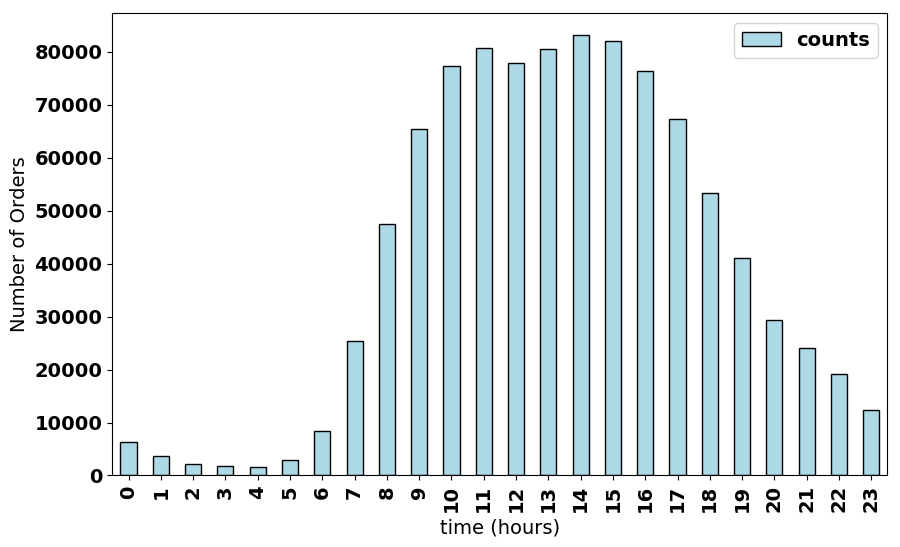

In [22]:
# what time of day are most orders placed?
orders_hours = training.groupby(['order_hour_of_day']).count()
orders_hours_counts = pd.DataFrame()
orders_hours_counts['counts'] = list(orders_hours['order_id'])

font = {'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

orders_hours_counts.plot.bar(color='lightblue', edgecolor='black', figsize=(10,6))
plt.xlabel('time (hours)')
plt.ylabel('Number of Orders')
plt.show()
plt.rcdefaults()

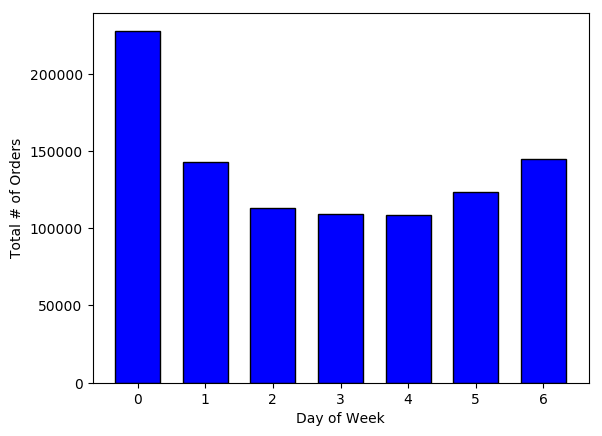

In [21]:
# what dow do people place orders?
orders_total = list(training.groupby('order_dow', as_index=False).count()['order_id'])

N = len(orders_total)
x = range(N)
width = 1/1.5
plt.bar(x, orders_total, width, color="blue", edgecolor='black')

plt.xlabel('Day of Week')
plt.ylabel('Total # of Orders')
plt.show()
plt.rcdefaults()

In [22]:
# what is the most purchased item at each hour? *ignoring a few edge cases here
orders_total_hours = training.groupby(['order_hour_of_day', 'product_name']).count()
orders_unstacked = orders_total_hours.unstack()

items=[]
for i in list(orders_unstacked):
    items.append(i[1])

high_order = []
for i in range(0, orders_unstacked.shape[0]):
    maximum = orders_unstacked.iloc[i,:].max()
    for j, k in enumerate(orders_unstacked.iloc[i,:]):
        if k == maximum:
            high_order.append(items[j]); break

hours = list(range(0,24))
most_ordered = pd.DataFrame()
most_ordered['Time (hours)'] = hours
most_ordered['Most Ordered Item'] = high_order
most_ordered.head(24)

,Time (hours),Most Ordered Item
0,0,Bag of Organic Bananas
1,1,Bag of Organic Bananas
2,2,Banana
3,3,Bag of Organic Bananas
4,4,Banana
5,5,Bag of Organic Bananas
6,6,Banana
7,7,Banana
8,8,Banana
9,9,Banana


The most ordered item at every hour of the day is bananas!  Perhaps instacart has been hijacked by monkeys?  We now turn our focus to items that are re-ordered.  First, we ask - what fraction of items ordered are re-orders?

In [23]:
# what fraction of items ordered are re-orders?
print ('fraction of ordered items that are re-orders:  ',
       training[training['reordered']==1].shape[0]/training.shape[0])

fraction of ordered items that are re-orders:   0.5986915490895895


In [24]:
# how many orders do we have for each user?
orders_numbers = list(training['order_number'].unique())
print ('min numbers of orders placed:  ', min(orders_numbers))
print ('max numbers of orders placed:  ', max(orders_numbers))

min numbers of orders placed:   4
max numbers of orders placed:   100


In [25]:
# how many unique products are there?
print("# of unique product_ids:  ", len(training['product_id'].unique()))
print('# of observations:  ', training.shape[0])

# of unique product_ids:   36158
# of observations:   970002


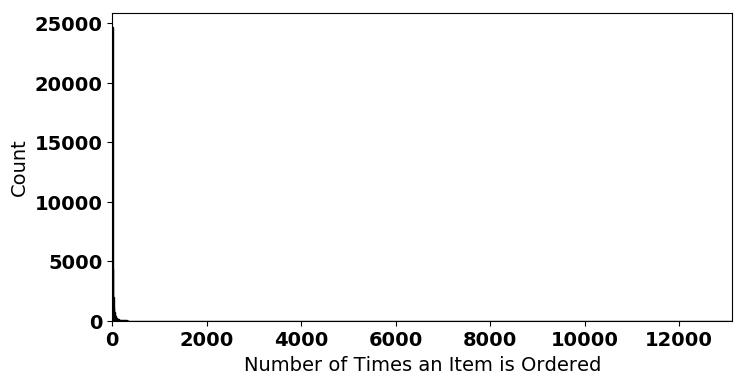

In [26]:
# holy smokes, that is a lot of items, but since there are 36158 items and 970002 observations
# i suspect that there are a few items that are ordered often?
items = list(training.groupby('product_id').count()['order_id'])

bins = np.arange(0,max(items), 10)
# plot the results
font = {'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

plt.figure(figsize=(8,4))
plt.hist(items, bins=bins, color='pink', edgecolor='black')
plt.xlabel('Number of Times an Item is Ordered')
plt.ylabel('Count')
plt.xlim([0, max(items)])
plt.show()
plt.rcdefaults()

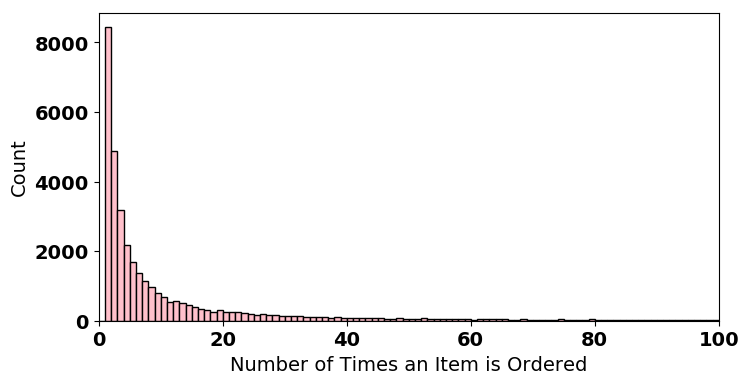

In [27]:
# that is not very informative
items = list(training.groupby('product_id').count()['order_id'])

bins = np.arange(0,max(items), 1)
# plot the results
font = {'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

plt.figure(figsize=(8,4))
plt.hist(items, bins=bins, color='pink', edgecolor='black')
plt.xlabel('Number of Times an Item is Ordered')
plt.ylabel('Count')
plt.xlim([0, 100])
plt.show()
plt.rcdefaults()

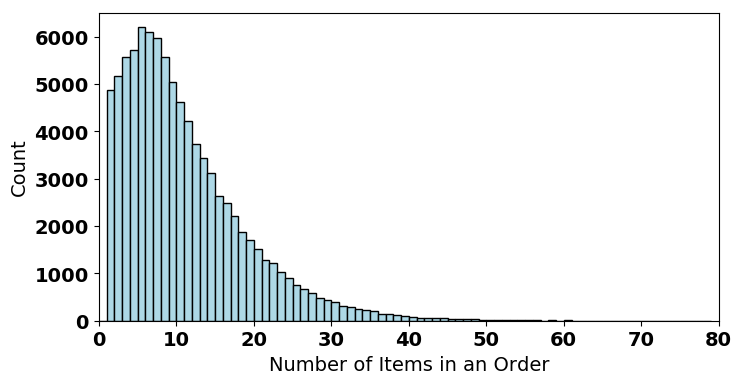

In [28]:
# number of items in an order
order_count = list(training.groupby('order_id').count()['product_id'])

bins = np.arange(0,max(order_count), 1)
# plot the results
font = {'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

plt.figure(figsize=(8,4))
plt.hist(order_count, bins=bins, color='lightblue', edgecolor='black')
plt.xlabel('Number of Items in an Order')
plt.ylabel('Count')
plt.xlim([0, max(order_count)])
plt.show()
plt.rcdefaults()

In [29]:
# are there more orders than users?
training.groupby(['user_id', 'order_id'], as_index=False).count().shape

(91846, 12)

In [30]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


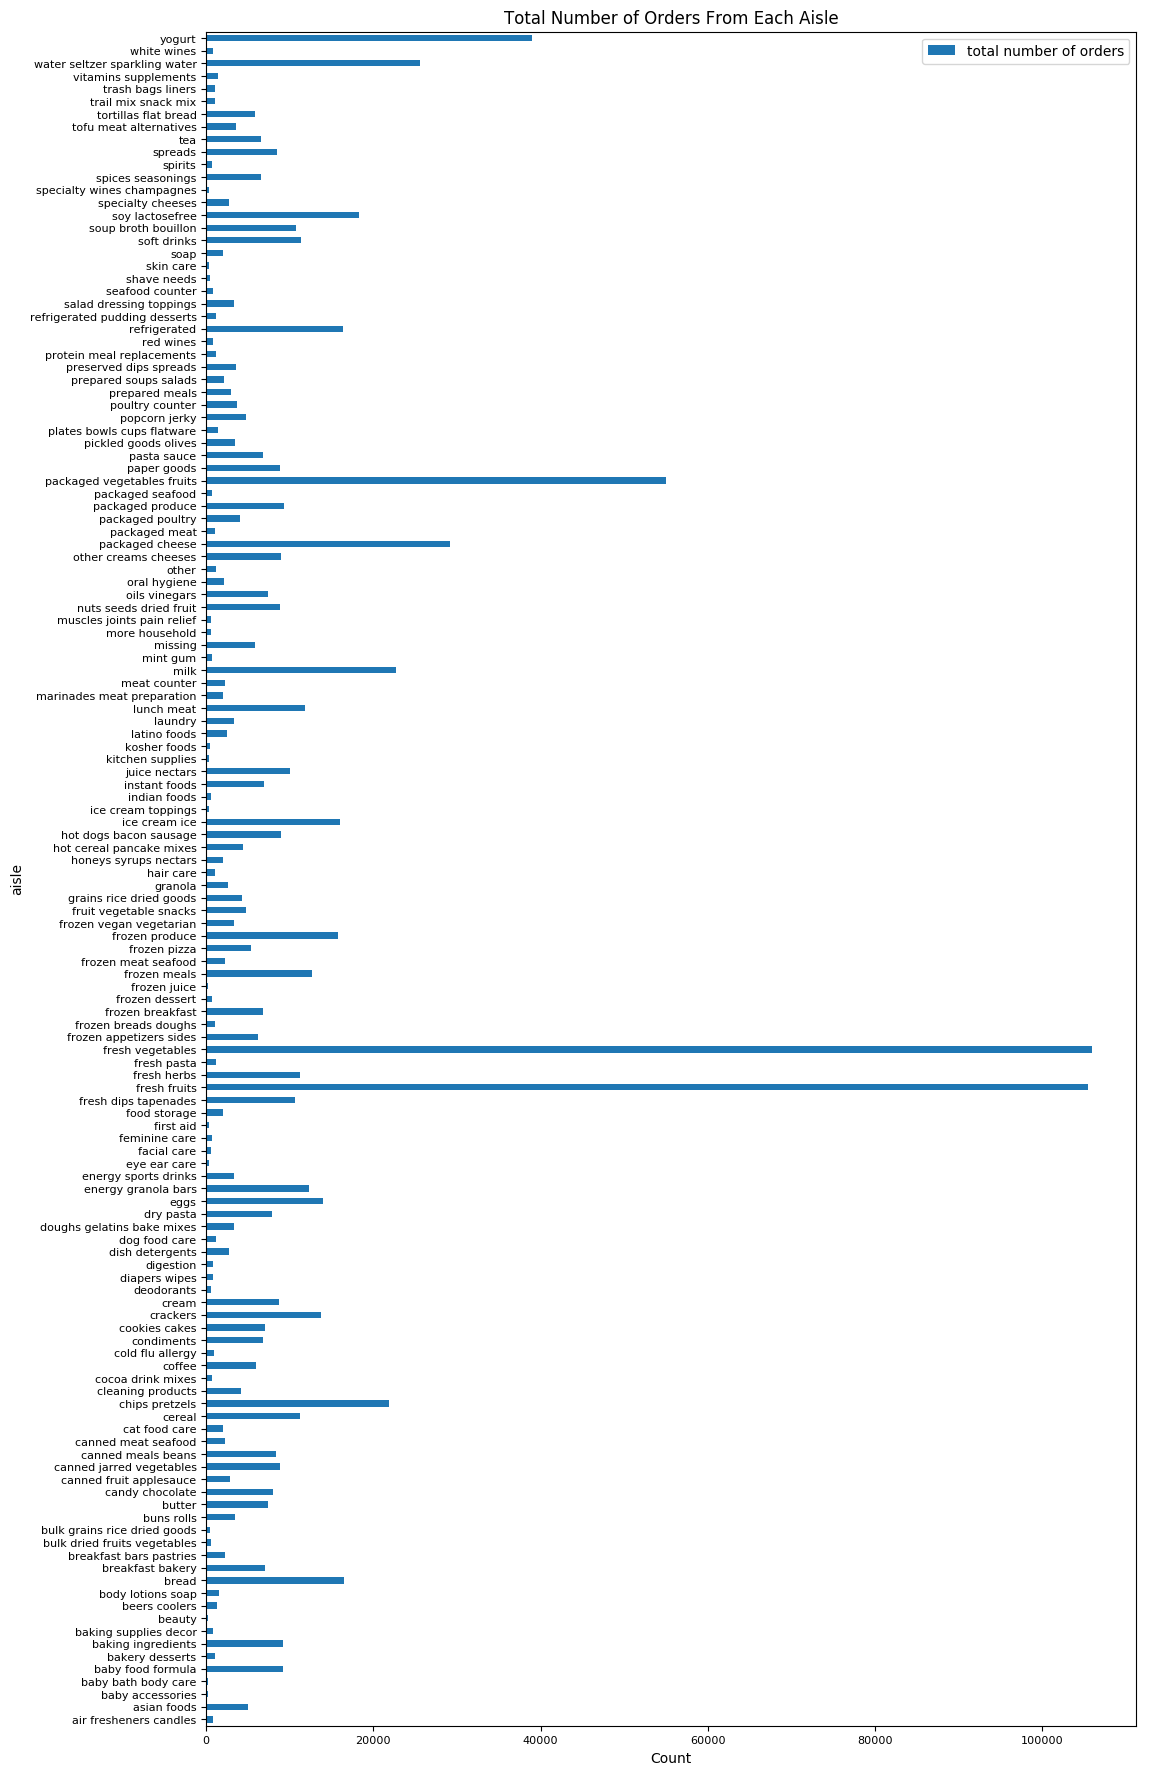

In [31]:
# notes so far - there is one order per user, each with ~ 10 items.
# the most ordered item is bananas, and most orders are placed around dinnertime and on day 0

# how many items are ordered from each aisle?
aisles = training.groupby('aisle', as_index=False).count()
aisles = aisles.iloc[:,:2]
aisles.columns = ['aisle', 'total number of orders']
aisles.plot.barh(x='aisle', y='total number of orders', stacked=True, figsize=(12,22), fontsize=8)
plt.xlabel('Count')
plt.title('Total Number of Orders From Each Aisle')
plt.show()

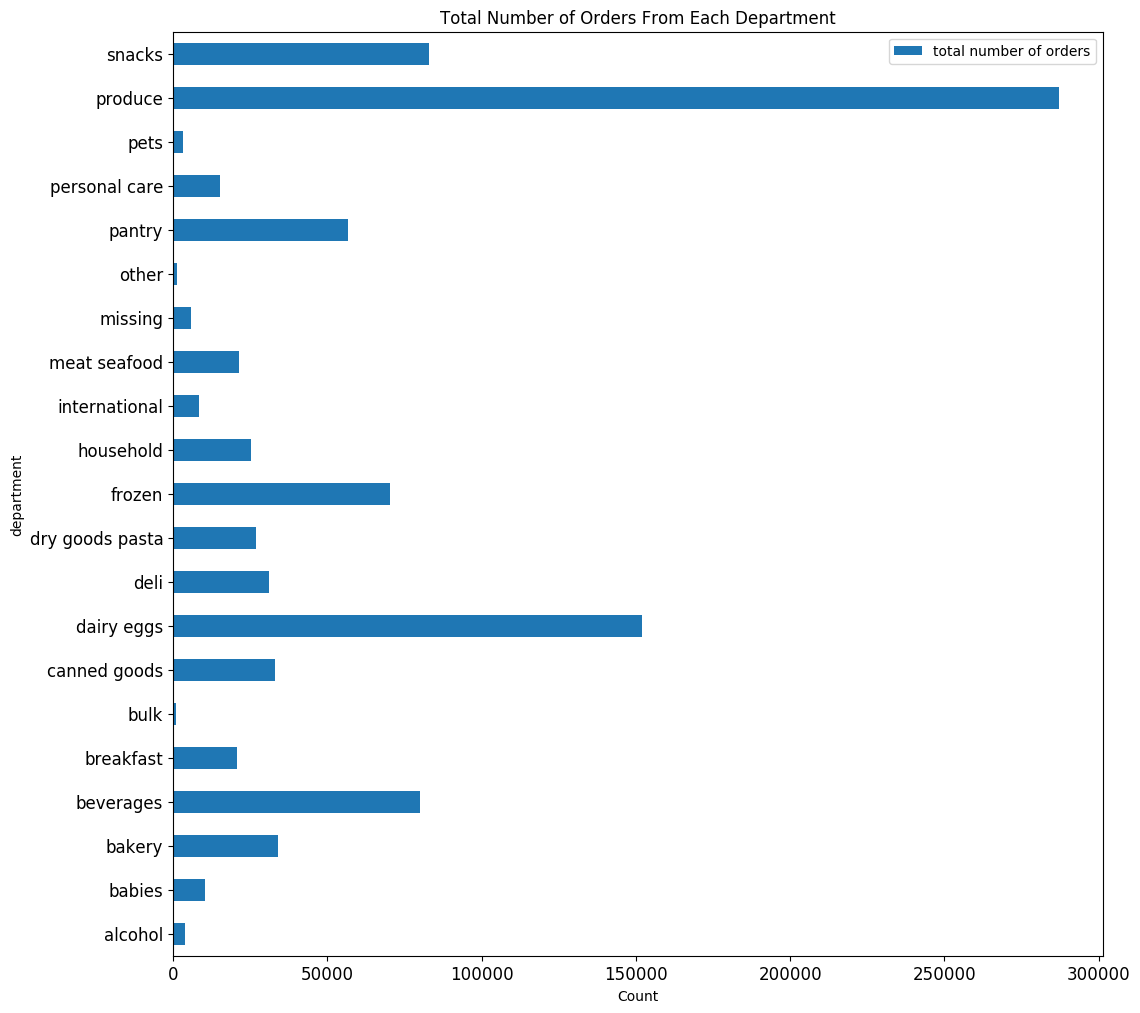

In [32]:
# fresh veggies, fresh fruit, packed veggies fruits, and yogurt dominate for aisle

# next, examine department
aisles = training.groupby('department', as_index=False).count()
aisles = aisles.iloc[:,:2]
aisles.columns = ['department', 'total number of orders']
aisles.plot.barh(x='department', y='total number of orders', stacked=True, figsize=(12,12), fontsize=12)
plt.xlabel('Count')
plt.title('Total Number of Orders From Each Department')
plt.show()

In [23]:
# as expected, produce is the most represented department, followed by dairy eggs
# basket size next
# add basket size to training data
basket = training.groupby('order_id', as_index=False).count()
basket = basket.iloc[:,:2]
basket.columns = ['order_id', 'basket_size']
training = pd.merge(training, basket, on='order_id')

In [34]:
# heat map of basket size and department
basket_depts = training.groupby(['basket_size', 'department'], as_index=False).count()

depts = list(basket_depts['department'].unique())
dept = {}
for i, j in enumerate(depts):
    dept[j] = i

# 21 departments and 80 max basket size 
baskets = np.zeros([80,21])
for i in range(0, basket_depts.shape[0]):
    dept_index = dept[basket_depts.loc[i, 'department']]
    basket = basket_depts.loc[i, 'basket_size']
    count = basket_depts.loc[i, 'order_id']
    baskets[basket-1, dept_index] = count

In [35]:
baskets_t = baskets.transpose()
baskets_t = pd.DataFrame(baskets_t)
baskets_t = baskets_t.set_index([depts])
baskets_t.columns = list(range(1,81))
baskets_t.head()

,1,2,3,4,5,6,7,8,9,10,...,71,72,73,74,75,76,77,78,79,80
alcohol,95.0,206.0,261.0,340.0,300.0,281.0,289.0,226.0,178.0,219.0,...,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
babies,41.0,66.0,96.0,124.0,182.0,245.0,250.0,353.0,329.0,346.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,2.0
bakery,161.0,282.0,523.0,734.0,1108.0,1294.0,1465.0,1667.0,1573.0,1603.0,...,0.0,4.0,0.0,3.0,5.0,5.0,0.0,0.0,0.0,4.0
beverages,1073.0,1810.0,2465.0,2920.0,3733.0,4133.0,4460.0,4184.0,4197.0,3898.0,...,0.0,5.0,0.0,10.0,12.0,14.0,0.0,0.0,0.0,14.0
breakfast,75.0,204.0,303.0,494.0,621.0,749.0,873.0,923.0,934.0,974.0,...,0.0,12.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,2.0


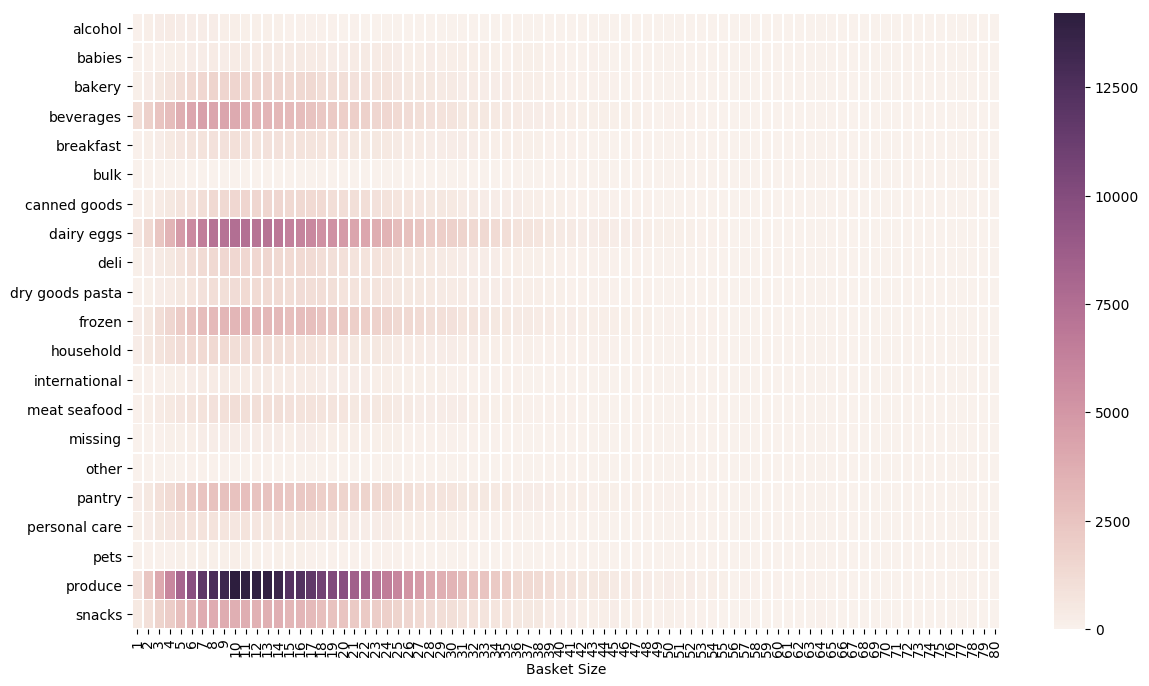

In [36]:
plt.figure(figsize=(14, 8))
sns.heatmap(baskets_t, linewidths=.5)
plt.xlabel('Basket Size')
plt.show()

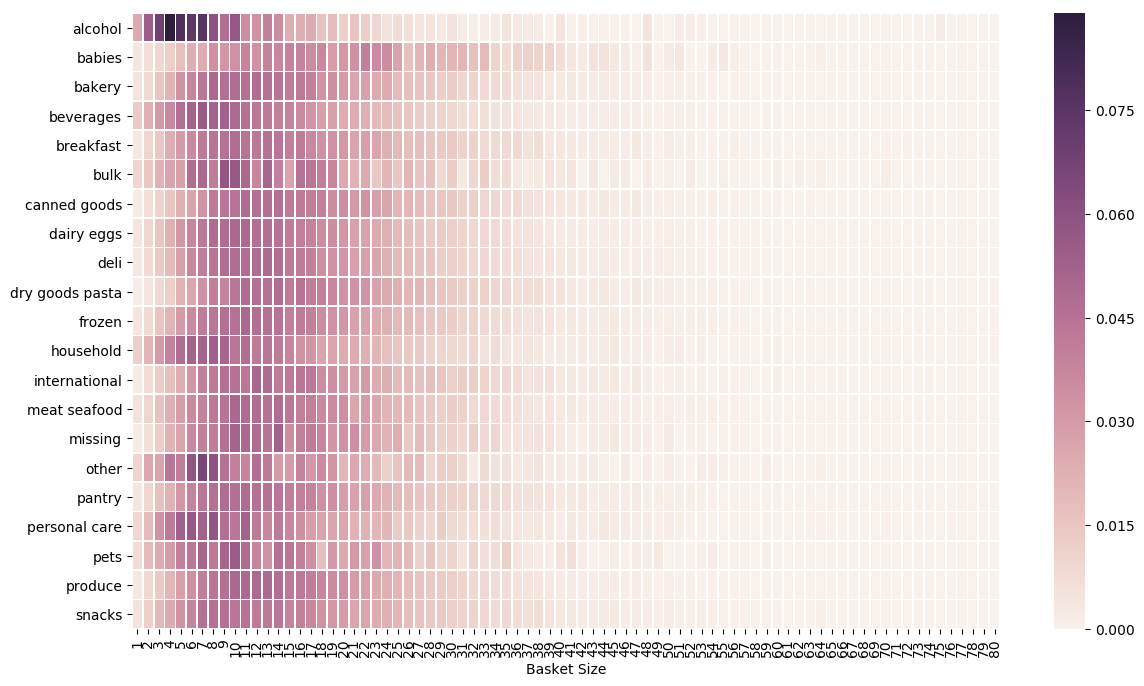

In [37]:
# normalize each aisle by total items
baskets_t_norm = baskets_t.copy()
for i in range(0,baskets_t_norm.shape[0]):
    baskets_t_norm.iloc[i,:] = baskets_t_norm.iloc[i,:]/sum(list(baskets_t_norm.iloc[i,:]))
    
plt.figure(figsize=(14, 8))
sns.heatmap(baskets_t_norm, linewidths=.5)
plt.xlabel('Basket Size')
plt.show()

In [20]:
# we now will add basket size as a feature to the testing set.  to do this we will
# add the average basket size from each user from from the prior data set (rudimentary, i know, should
# probably explore this feature and make a more complex prediction)

test_basket = prior.groupby(['user_id', 'order_id'], as_index=False).count()
test_basket = test_basket.loc[:,['user_id', 'product_id']]
test_basket = pd.DataFrame(test_basket.groupby('user_id', as_index=False)['product_id'].mean())

users_prior = list(test_basket['user_id'])
basket_prior = list(test_basket['product_id'])

test_users = list(testing['user_id'].unique())

basket_dict = {}
for i, j in zip(users_prior, basket_prior):
    if i in test_users:
        basket_dict[i] = j

In [21]:
# now add basket size to the test data
test_users = list(testing['user_id'])
basketSize = []
for i in test_users:
    basketSize.append(int(basket_dict[i]))
                      
testing['basket_size'] = basketSize
testing.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,basket_size
0,2565571,7,prior,1,3,9,NaN,10
1,2402008,7,prior,2,1,19,30.0,10
2,121053,7,prior,3,0,18,30.0,10
3,1695742,7,prior,4,2,10,9.0,10
4,3321109,7,prior,5,5,18,3.0,10


In [ ]:
'''
# finally, add each item that a user has ordered to the test and training data sets from the prior
sizes = list(range(1, testing['basket_size'].max() + 1))
add_to_cart_order = []
basket_sizers = []

for i in sizes:
    for j in range(1, i+1):
        add_to_cart_order.append(j)
        basket_sizers.append(i)

order_cart = pd.DataFrame()
order_cart['add_to_cart_order'] = add_to_cart_order
order_cart['basket_size'] = basket_sizers

testing = pd.merge(testing, order_cart, on='basket_size')
testing.head()
'''

In [22]:
# next, remove NaN and replace with 0
testing = testing.fillna(0)
testing.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,basket_size
0,2565571,7,prior,1,3,9,0.0,10
1,2402008,7,prior,2,1,19,30.0,10
2,121053,7,prior,3,0,18,30.0,10
3,1695742,7,prior,4,2,10,9.0,10
4,3321109,7,prior,5,5,18,3.0,10


In [23]:
# next, we need to fill in all of the items that a given user has ever ordered into the training and test data
prior_testing = prior.groupby(['user_id', 'product_id'], as_index=False).count()
prior_testing = prior_testing.loc[:, ['user_id', 'product_id']]
testing = pd.merge(testing, prior_testing, on='user_id')
testing.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,basket_size,product_id
0,2565571,7,prior,1,3,9,0.0,10,274
1,2565571,7,prior,1,3,9,0.0,10,519
2,2565571,7,prior,1,3,9,0.0,10,4920
3,2565571,7,prior,1,3,9,0.0,10,4945
4,2565571,7,prior,1,3,9,0.0,10,6361


In [28]:
# write these beasts to disc
#testing.to_csv('data450/testing_082217.csv.gz', compression='gzip')
#training.to_csv('data450/training_082217.csv.gz', compression='gzip')
#prior.to_csv('data450/prior_082217.csv.gz', compression='gzip')

In [53]:
#training = pd.read_csv('data450/training_082217.csv.gz', engine='c')
#training = training.iloc[:,1:]

#testing = pd.read_csv('data450/testing_082217.csv.gz', engine='c')
#testing = testing.iloc[:,1:]

In [24]:
# finally, fill in all of the items that a user has ordered into the training data
training['ordered'] = 1
prior_training = pd.merge(prior, train_users, how='inner', on='user_id')

In [25]:
prior_training['ordered'] = 0
full_training_join = [training, prior_training]
full_training = pd.concat(full_training_join)

In [26]:
# add additional basket sizes to training data
basket = full_training.groupby('order_id', as_index=False).count()
basket = basket.iloc[:,:2]
basket.columns = ['order_id', 'basket_size']
full_training = pd.merge(full_training, basket, on='order_id')

In [27]:
# save this to disc and goodbye
full_training.to_csv('data450/full_training.csv.gz', compression='gzip')

In [28]:
# finally, we will format the data for model building
features_train = ['order_id',
           'user_id',
           'order_number',
           'order_dow',
           'order_hour_of_day',
           'days_since_prior_order',
           'product_id',
           'ordered',
           'basket_size']

training_nn = full_training.loc[:, features_train]
training_nn.to_csv('data450/training_nn.csv.gz', compression='gzip')

In [90]:
# save the testing data and get ready to make a model
testing.to_csv('data450/testing_nn.csv.gz', compression='gzip')

## Model Building  

Now that we have performed feature engineering and shaped the data into an appropriate format we can build a model.  I am going to build a neural network, not because I feel that this is the best type of model for this problem, but rather because they are fun I want to learn more about them!

In [3]:
# first, define a few functions that will help us evaluate model performance
# Evaluate predictions
def confusion(actual, predictions):
    '''
    generate a confusion matrix
    '''
    confusion_mat = pd.DataFrame(confusion_matrix(actual, predictions))
    confusion_mat.columns = ['Predicted No Order', 'Predicted Order']
    confusion_mat.index = ['Actual No Order', 'Actual Order']
    return confusion_mat

In [4]:
def f1score(actual, preds):
    actual = list(actual)
    preds = list(preds)
    
    tp = 0; fp = 0; tn = 0; fn = 0
    for i, j in zip(actual, preds):
        if i ==1 and j == 1:
            tp += 1.
        if i == 0 and j == 1:
            fp += 1.
        if i == 1 and j == 0:
            fn += 1.
        if i == 0 and j == 0:
            tn += 1.

    if tp + fp == 0:
        precision = 0
    else:
        precision = tp/(tp+fp)
      
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp/(tp+fn)
    
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2.*precision*recall/(precision + recall)
    
    print('precision:  ', precision)
    print('recall:  ', recall)
    return f1

In [3]:
# here I will work out the details of building a neural network
testing_nn = pd.read_csv('data450/testing_nn.csv.gz', engine='c')
testing_nn = testing_nn.iloc[:,1:]

training_nn = pd.read_csv('data450/training_nn.csv.gz', engine='c')
training_nn = training_nn.iloc[:,1:]
# drop nan from days since prior order in testing
training_nn = training_nn.fillna(0)

In [8]:
# add aisle and dept ID
training_nn_aisles = pd.merge(training_nn, products, on='product_id')
training_nn_aisles.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,ordered,basket_size,product_name,aisle_id,department_id
0,1,112108,4,4,10,9.0,49302,1,8,Bulgarian Yogurt,120,16
1,816049,47901,14,4,6,16.0,49302,1,16,Bulgarian Yogurt,120,16
2,1242203,2993,15,0,7,7.0,49302,1,10,Bulgarian Yogurt,120,16
3,1787378,187205,5,4,14,30.0,49302,1,8,Bulgarian Yogurt,120,16
4,2445303,199120,49,3,20,7.0,49302,1,14,Bulgarian Yogurt,120,16


In [9]:
# split the training data for model buillding and validation
X_train, X_test, y_train, y_test = train_test_split(training_nn_aisles.drop(['ordered'], axis=1),
                                                                   training_nn['ordered'],
                                                                   test_size=0.3,
                                                                   random_state=321)

In [ ]:
# select the features for model building
features = ['order_number',
           'order_dow',
           'order_hour_of_day',
           'days_since_prior_order',
           'basket_size',
           'aisle_id',
           'department_id']

X_train = X_train.loc[:, features]
X_test = X_test.loc[:, features]

In [ ]:
# one hot encode order_dow
one_hot = pd.get_dummies(X_train['order_dow'])
X_train = X_train.drop('order_dow', axis = 1)
X_train = X_train.join(one_hot)

one_hot = pd.get_dummies(X_test['order_dow'])
X_test = X_test.drop('order_dow', axis = 1)
X_test = X_test.join(one_hot)

In [ ]:
# convert to numpy array
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

# convert class to categorical
y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)

In [4]:
# add aisle info to to the test data 
# add aisle ID
testing_nn_aisles = pd.merge(testing_nn, products, on='product_id')

# select the features for model building
features = ['order_number',
           'order_dow',
           'order_hour_of_day',
           'days_since_prior_order',
           'basket_size',
           'aisle_id',
           'department_id']

testing_nn_aisles = testing_nn_aisles.loc[:, features]

# one hot encode order_dow
one_hot = pd.get_dummies(testing_nn_aisles['order_dow'])
testing_nn_aisles = testing_nn_aisles.drop('order_dow', axis = 1)
testing_nn_aisles = testing_nn_aisles.join(one_hot)

# convert to numpy array
testing_nn_np = testing_nn_aisles.as_matrix()

In [43]:
# try weighting, with 200 epochs
class_weight = {0 : 1.,
    1: 20.}

# build a model
modelW5 = Sequential()

modelW5.add(Dropout(0.2, input_shape=(13,)))
modelW5.add(Dense(128, activation='relu', input_dim=13))

modelW5.add(Dropout(0.2))
modelW5.add(Dense(64, activation='relu'))

modelW5.add(Dropout(0.2))
modelW5.add(Dense(32, activation='relu'))

modelW5.add(Dense(8, activation='relu'))

modelW5.add(Dense(1, activation='sigmoid'))

# compile the model
modelW5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# run!
modelW5.fit(X_train, y_train, epochs=200, batch_size=1000, verbose=1, class_weight=class_weight)

Epoch 1/200
10811472/10811472 [==============================] - 83s - loss: 1.1526 - acc: 0.6763    
Epoch 2/200
10811472/10811472 [==============================] - 76s - loss: 1.0431 - acc: 0.6666    
Epoch 3/200
10811472/10811472 [==============================] - 77s - loss: 1.0234 - acc: 0.6465    
Epoch 4/200
10811472/10811472 [==============================] - 76s - loss: 1.0109 - acc: 0.7162    
Epoch 5/200
10811472/10811472 [==============================] - 77s - loss: 1.0067 - acc: 0.7072    
Epoch 6/200
10811472/10811472 [==============================] - 78s - loss: 1.0002 - acc: 0.7077    
Epoch 7/200
10811472/10811472 [==============================] - 77s - loss: 0.9945 - acc: 0.7046    
Epoch 8/200
10811472/10811472 [==============================] - 77s - loss: 0.9926 - acc: 0.7041    
Epoch 9/200
10811472/10811472 [==============================] - 77s - loss: 0.9903 - acc: 0.6965    
Epoch 10/200
10811472/10811472 [==============================] - 77s - loss: 0.98

10811472/10811472 [==============================] - 72s - loss: 0.9664 - acc: 0.6131    
Epoch 160/200
10811472/10811472 [==============================] - 72s - loss: 0.9673 - acc: 0.6139    
Epoch 161/200
10811472/10811472 [==============================] - 72s - loss: 0.9657 - acc: 0.6137    
Epoch 162/200
10811472/10811472 [==============================] - 72s - loss: 0.9687 - acc: 0.6130    
Epoch 163/200
10811472/10811472 [==============================] - 72s - loss: 0.9662 - acc: 0.6138    
Epoch 164/200
10811472/10811472 [==============================] - 72s - loss: 0.9685 - acc: 0.6134    
Epoch 165/200
10811472/10811472 [==============================] - 72s - loss: 0.9669 - acc: 0.6131    
Epoch 166/200
10811472/10811472 [==============================] - 72s - loss: 0.9674 - acc: 0.6144    
Epoch 167/200
10811472/10811472 [==============================] - 72s - loss: 0.9663 - acc: 0.6148    
Epoch 168/200
10811472/10811472 [==============================] - 72s - loss:

In [44]:
# save this beast, just in case
modelW5.save('instacart_nn_weight5.h5')

In [5]:
from keras.models import load_model
modelW5 = load_model('instacart_nn_weight5.h5')

In [91]:
# make predictions probs
probsW5 = modelW5.predict_proba(X_test)

4632832/4633488 [============================>.] - ETA: 0s

In [92]:
# plot probability vs f1 score
probs = [i/100 for i in range(0,100,5)]
f1_s = []

for i in probs:
    preds = []
    for j in probsW5:
        if j > i:
            preds.append(1)
        else:
            preds.append(0)
    f1_s.append(f1score(y_test, preds))

precision:   0.0629001305280169
recall:   1.0
precision:   0.12657355966611986
recall:   0.7667123010358659
precision:   0.13476970493656745
recall:   0.7165590999392686
precision:   0.14078901145468337
recall:   0.6999317200039802
precision:   0.15429670526583747
recall:   0.6883927437921817
precision:   0.15564047932555766
recall:   0.6850061932358199
precision:   0.1574095789860676
recall:   0.6816539542352469
precision:   0.16035667300102324
recall:   0.6775159806071087
precision:   0.17085505716289798
recall:   0.64855359636572
precision:   0.17253239393811784
recall:   0.6466458738638586
precision:   0.18047339551034833
recall:   0.6448239302514694
precision:   0.20221231765731051
recall:   0.6377729055368557
precision:   0.20324762630509424
recall:   0.636942565886765
precision:   0.20912744380365428
recall:   0.6361636935703575
precision:   0.24574277135957184
recall:   0.5167354613360233
precision:   0.2475183685956639
recall:   0.5163305849777147
precision:   0.26180677655036

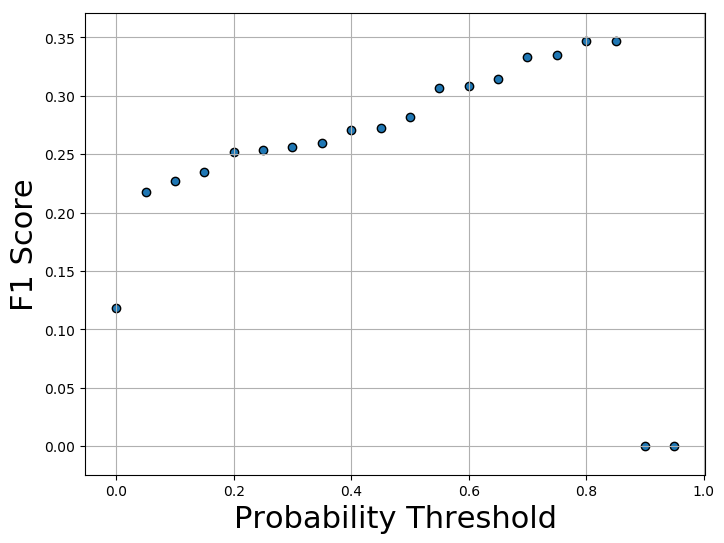

In [94]:
plt.rcdefaults()
plt.figure(figsize=(8,6))
plt.scatter(probs, f1_s, edgecolors='black')
plt.xlabel('Probability Threshold', fontsize=22)
plt.ylabel('F1 Score', fontsize=22)
plt.grid()
plt.show()

In [6]:
# looks like 0.8 is a good cutoff
# make predictions
predict_real_aisles = modelW5.predict_proba(testing_nn_np)
#testing_nn_aisles['ordered'] = list(predict_real_aisles)

66817056/66818720 [============================>.] - ETA: 0s

In [ ]:
# write these probs to a text file in case i get booted
#probs_final = open('probs_final.txt', 'w')
#for i in list(predict_real_aisles):
#    probs_final.write("%s\n" % i)
#probs_final.close()

In [7]:
# get orders
final_preds = testing_nn[['order_id', 'product_id']]
final_preds['ordered'] = list(predict_real_aisles)
final_preds.head()

/Users/jasondean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,order_id,product_id,ordered
0,2565571,274,[0.0353481]
1,2565571,519,[0.0217907]
2,2565571,4920,[0.0201805]
3,2565571,4945,[0.0276274]
4,2565571,6361,[0.02337]


In [ ]:
temp = pd.DataFrame(final_preds.groupby(["order_id"])["ordered"].nlargest(1))
spots = temp.index.tolist()

keepers = []
for i in spots:
    keepers.append(i[1])

submission = final_preds.iloc[keepers,:]

orders = list(submission['order_id'])
products = list(submission['product_id'])

orders = list(submission['order_id'])
products = list(submission['product_id'])

submit = open('submission_JTD.txt', 'w')
for i, j in zip(orders, products):
    output = str(i) + ', ' + str(j)
    submit.write("%s\n" % output)

submit.close()

In [ ]:
# goodbye!